# Fisher forecast using Compton-y power spectrum

In [1]:
import numpy as np, sys, os, warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

%load_ext autoreload
%autoreload 2

#%pylab notebook
%matplotlib inline
from pylab import *
cmap = cm.RdYlBu_r

In [2]:
rcParams['figure.dpi'] = 150
rcParams["figure.facecolor"] = 'white'

In [3]:
import fisher_tools

In [12]:
#read Compton-y power spectrum derivatives from Eriwn Lau (shared over CMB-S4 slack on 20231103)
cl_yy_deriv_dic_fname = 'data/dcl_dparams.npy'
cl_yy_deriv_dic = np.load(cl_yy_deriv_dic_fname, allow_pickle=True).item()
lmax = len( cl_yy_deriv_dic['sigma_8'] )
print(lmax)
el = np.arange(lmax)

#param names
params = sorted( list(cl_yy_deriv_dic.keys()) )
fid_param_values_dict = {'eps_f': 4.5, 'A_nt': 0.42, 'sigma_8': 0.81, 'Omega_m': 0.32}


#get Compton-y power spectrum
cl_yy_fname = 'data/compton_y_power_spectra.npy'
el_, cl_yy, cl_yy_median = np.load(cl_yy_fname, allow_pickle=True).item()['Fiducial']
cl_yy = np.interp(el, el_, cl_yy) #simply interpolate

#get Compton-y noise power spectrum
cl_yy_noise_fname = 'data/ilc_weights_residuals.npy'
tmp_cl_yy_noise_dic = np.load(cl_yy_noise_fname, allow_pickle = True).item()
el_ = tmp_cl_yy_noise_dic['els']
cl_yy_noise_dic = tmp_cl_yy_noise_dic['ilc_residuals']
print(cl_yy_noise_dic.keys()) #experiments

#experiments and fsky
exp_fsky_dic = {'CMB-HD': 0.5, 'S4-Ultra Deep': 0.03, 'S4-Wide': 0.5}
pl_exp_specs_dic = {'CMB-HD': ['goldenrod', '-'], 'S4-Ultra Deep': ['orangered', '-'], 'S4-Wide': ['darkgreen', '-']}


12001
dict_keys(['CMB-HD', 'S4-Ultra Deep', 'S4-Wide', 'SPT-3G', 'SO-Goal', 'SPTpol', 'SO-Baseline', 'SPT-SZ'])


CMB-HD 0.5 (4, 4)
S4-Ultra Deep 0.03 (4, 4)
S4-Wide 0.5 (4, 4)


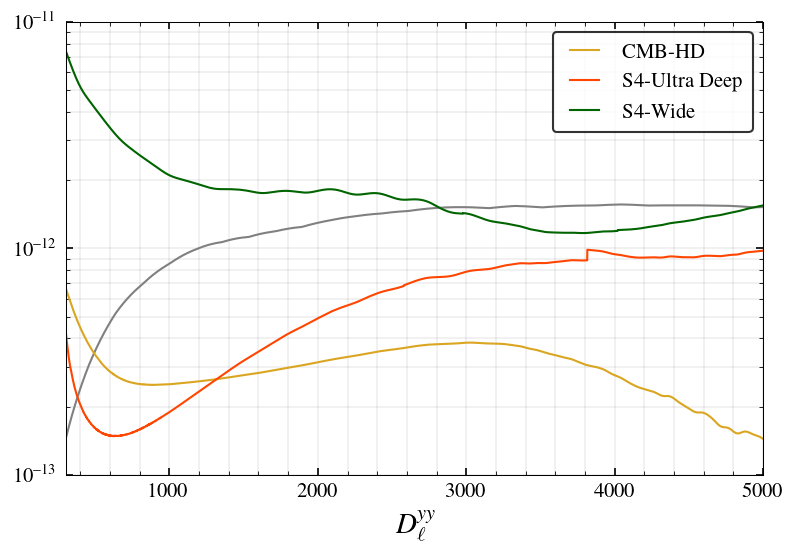

In [13]:
#perform Fisher forecasting now
lmin, lmax = 250, 5000
fisher_dic = {}
debug = True
if debug:
    dl_fac = el * (el+1)/2/np.pi
    ax = subplot(111, yscale = 'log')
    plot(el, dl_fac * cl_yy, 'gray')

for exp in exp_fsky_dic:
    
    #fsky
    fsk_val = exp_fsky_dic[exp]
    
    #total cl
    cl_signal = np.copy(cl_yy)
    cl_noise = cl_yy_noise_dic[exp]
    cl_total = cl_signal + cl_noise
    
    if debug:
        plot(el, dl_fac * cl_noise, color = pl_exp_specs_dic[exp][0], label = r'%s' %(exp))
        
    
    #get delta_cl -- knox errors
    delta_cl = fisher_tools.get_knox_errors(el, cl_total, fsk_val)
    
    #get Fisher matrix
    fisher_mat = fisher_tools.get_ymap_power_spectrum_fisher(el, cl_yy_deriv_dic, delta_cl, params, lmin = lmin, lmax = lmax)
    print(exp, fsk_val, fisher_mat.shape)
    
    #push into dic
    fisher_dic[exp] = fisher_mat
    
if debug:
    grid(True, which = 'both', axis = 'both', lw = 0.1, alpha = 0.5)
    legend(loc = 1)
    xlim(300, 5000); ylim(1e-13, 1e-11)
    xlabel(r'Multipole $\ell$', fontsize = 14)
    ylabel(r'$D_{\ell}^{yy}$', fontsize = 14)
    show()
    

<Figure size 900x600 with 0 Axes>

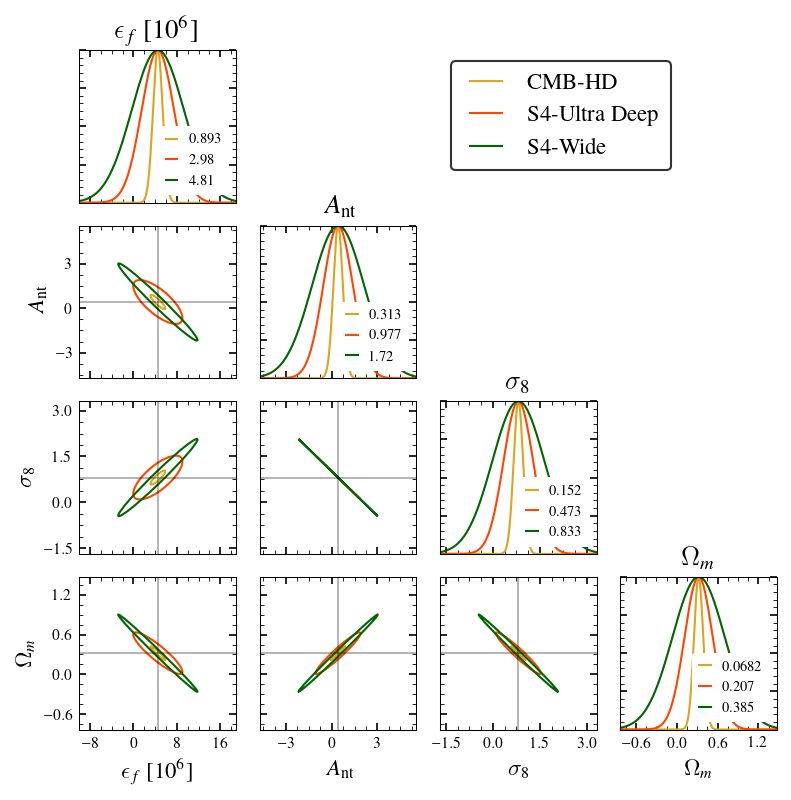

In [22]:
color_dic, ls_dic = {}, {}
for exp in pl_exp_specs_dic:
    color_dic[exp], ls_dic[exp] = pl_exp_specs_dic[exp]

##desired_params_to_plot = ['A_nt', 'eps_f', 'sigma_8', 'Omega_m']
desired_params_to_plot = ['eps_f', 'A_nt', 'sigma_8', 'Omega_m']
tr, tc = len(desired_params_to_plot), len(desired_params_to_plot)
fix_axis_range_to_xxsigma = 3.

clf()
figure(figsize = (tr+2, tc+2))
subplots_adjust(hspace=0.15, wspace = 0.15)
fsval = 11
color_dic, ls_dic = fisher_tools.make_triangle_plot(fisher_dic, tr, tc, params, fid_param_values_dict, desired_params_to_plot, fsval = fsval, color_dic = color_dic, ls_dic = ls_dic, fix_axis_range_to_xxsigma = fix_axis_range_to_xxsigma)#, one_or_two_sigma = 1, fsval = 12, noofticks = 4)

#add legend
if tr > 2:
    leg_sbpl = 3
else:
    leg_sbpl = 2
ax = subplot(tr, tc, leg_sbpl)
for exp in fisher_dic:
    labval = r'%s' %(exp)
    plot([], [], color = color_dic[exp], ls = ls_dic[exp], label = labval)

axis('off')
legend(loc = 2, fontsize = fsval)    
show()